In [2]:
# Import libraries
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Data paths (update these with your actual paths)
train_dir = r"D:\Brain_Tumor\Training"
test_dir = r"D:\Brain_Tumor\Testing"
print(train_dir)

D:\Brain_Tumor\Training


In [3]:
print(test_dir)

D:\Brain_Tumor\Testing


In [4]:
# Load and shuffle training data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)


In [5]:
# Load and shuffle testing data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)


In [6]:
# Display sample images
def show_samples(paths, labels, n_samples=10):
    plt.figure(figsize=(15, 8))
    for i in range(n_samples):
        idx = random.randint(0, len(paths)-1)
        img = Image.open(paths[idx])
        img = img.resize((128, 128))

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"Label: {labels[idx]}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Training samples:


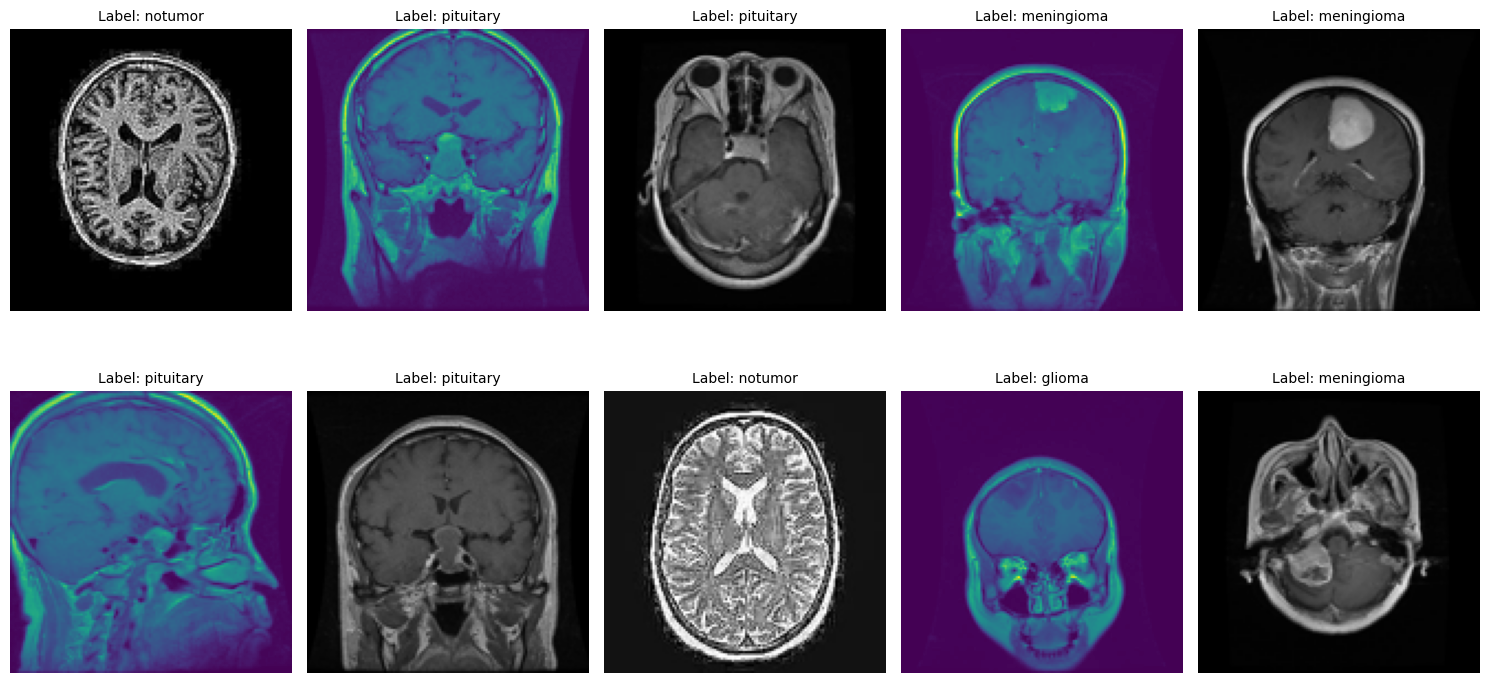

In [7]:
print("Training samples:")
show_samples(train_paths, train_labels)


Testing samples:


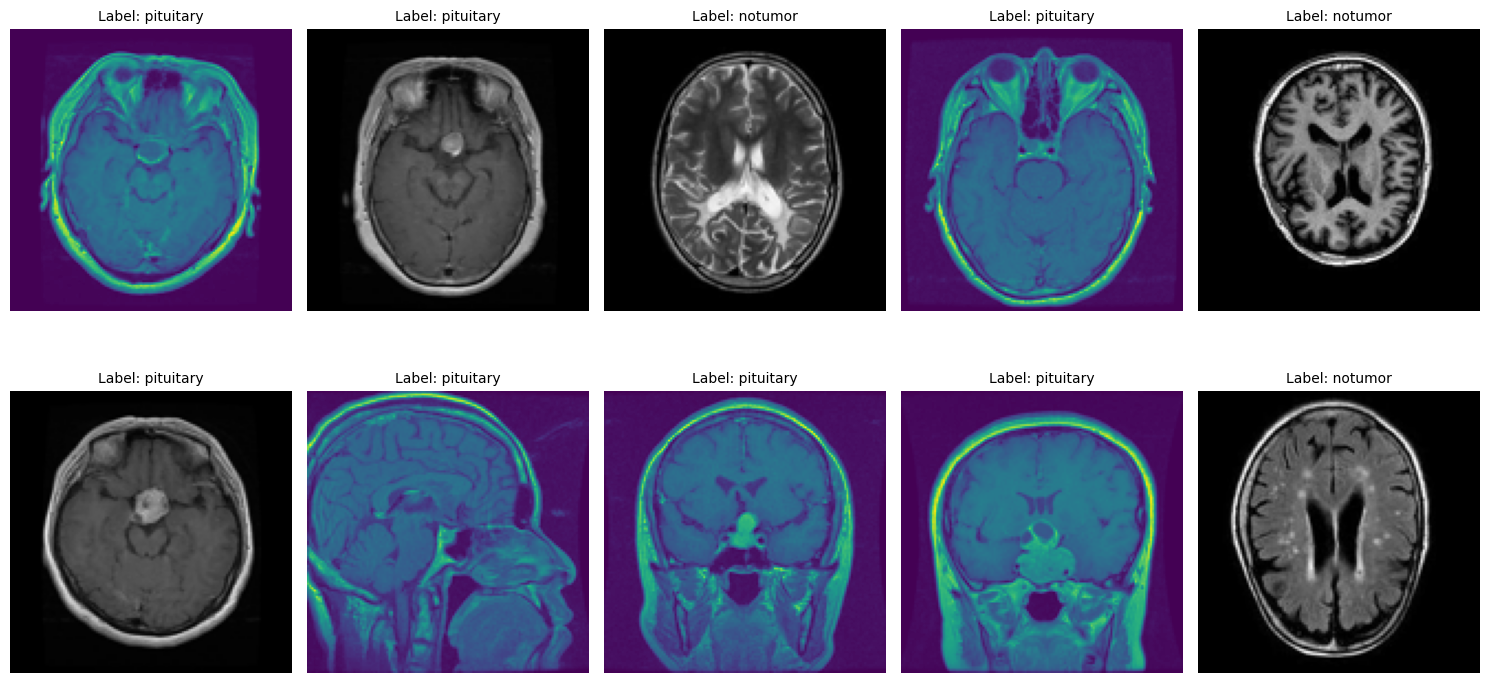

In [8]:
print("\nTesting samples:")
show_samples(test_paths, test_labels)


In [9]:
# Image processing and augmentation
def process_image(image_path, augment=False):
    img = load_img(image_path, target_size=(128, 128))
    img = img_to_array(img) / 255.0  # Normalize to [0,1]

    if augment:
        # Random brightness
        img = ImageEnhance.Brightness(Image.fromarray((img * 255).astype('uint8'))).enhance(random.uniform(0.8, 1.2))
        # Random contrast
        img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2))
        img = np.array(img) / 255.0

    return img

# Encode labels
class_names = sorted(os.listdir(train_dir))
label_to_idx = {name: i for i, name in enumerate(class_names)}

def encode_labels(labels):
    return np.array([label_to_idx[label] for label in labels])

# Data generator
def data_generator(paths, labels, batch_size=32, augment=False):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_images = np.array([process_image(p, augment) for p in batch_paths])
            batch_labels = encode_labels(labels[i:i+batch_size])
            yield batch_images, batch_labels


In [10]:
def augment_image(image):
    image = Image.fromarray((image * 255).astype(np.uint8))  # Ensure proper conversion
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0  # Normalize pixel values
    return image

# Load and preprocess images
IMAGE_SIZE = 128

def open_image(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.array(image) / 255.0  # Normalize before augmentation
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encode labels
def encode_label(labels):
    unique_labels = sorted(set(train_labels))  # Maintain consistent mapping
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data Generator
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_image(batch_paths)  # Fix function call
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  
            yield batch_images, batch_labels  

In [11]:
# Model architecture
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last few layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [12]:
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

In [13]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
# Training parameters
batch_size = 12
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

# Train the model
history = model.fit(
    data_generator(train_paths, train_labels, batch_size=batch_size, augment=True),
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    validation_data=data_generator(test_paths, test_labels, batch_size=batch_size),
    validation_steps=validation_steps
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/3
476/476 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - accuracy: 0.7131 - loss: 0.7128 - val_accuracy: 0.8693 - val_loss: 0.3510
Epoch 2/3
476/476 ━━━━━━━━━━━━━━━━━━━━ 605s 1s/step - accuracy: 0.9048 - loss: 0.2705 - val_accuracy: 0.9076 - val_loss: 0.2230
Epoch 3/3
476/476 ━━━━━━━━━━━━━━━━━━━━ 631s 1s/step - accuracy: 0.9272 - loss: 0.1940 - val_accuracy: 0.9161 - val_loss: 0.1975


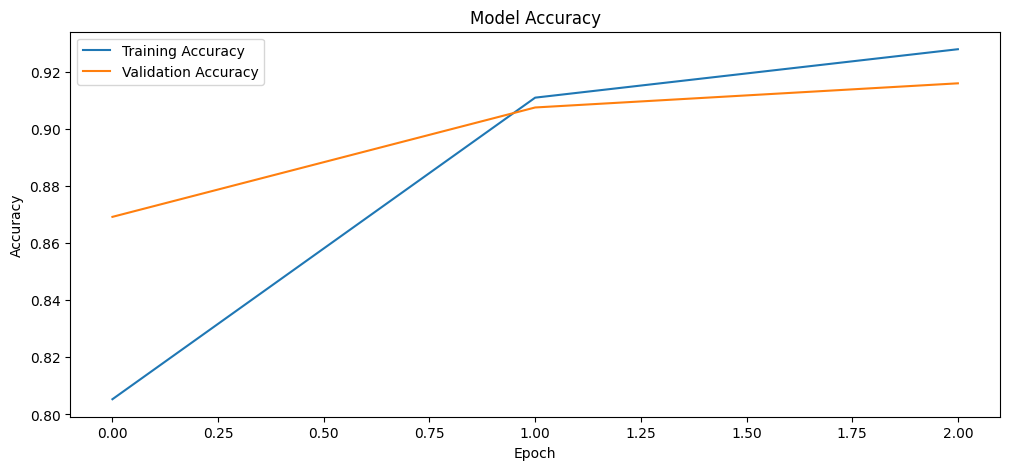

In [15]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

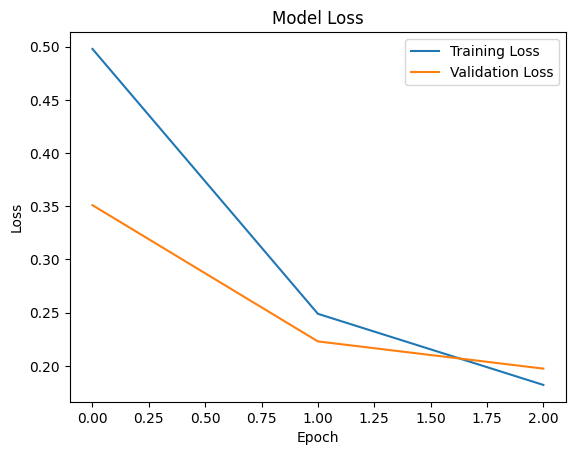

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.80      0.87       300
  meningioma       0.83      0.87      0.85       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.92      0.97      0.95       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



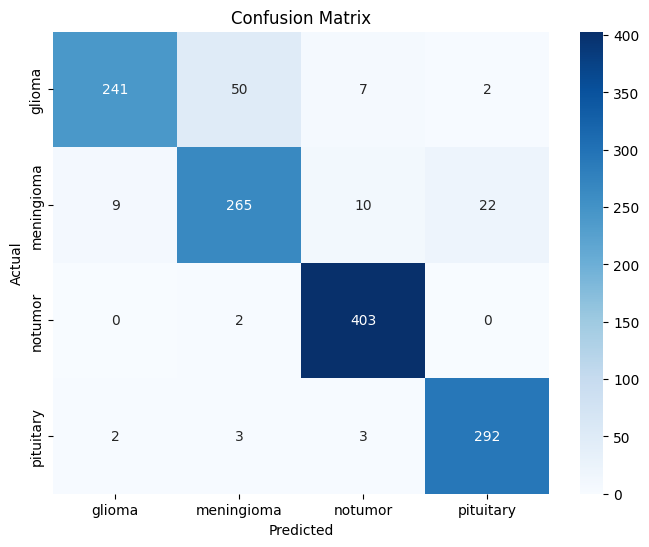

In [17]:
def evaluate_model(model, test_paths, test_labels):
    # Prepare test data
    X_test = np.array([process_image(p) for p in test_paths])
    y_test = encode_labels(test_labels)

    # Predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(model, test_paths, test_labels)

In [19]:
def predict_tumor(image_path, model):
    try:
        # Process image
        img = process_image(image_path)
        img = np.expand_dims(img, axis=0)

        # Make prediction
        preds = model.predict(img)[0]
        pred_class = np.argmax(preds)
        confidence = np.max(preds)

        # Display results
        plt.figure(figsize=(8, 6))
        plt.imshow(Image.open(image_path))
        plt.axis('off')

        result = "No tumor" if class_names[pred_class] == 'no_tumor' else f"Tumor: {class_names[pred_class].replace('_', ' ')}"
        plt.title(f"{result}\nConfidence: {confidence*100:.2f}%", fontsize=12, pad=20)
        plt.show()

        print("\nDetailed probabilities:")
        for name, prob in zip(class_names, preds):
            print(f"{name.replace('_', ' '):<20}: {prob*100:.2f}%")

    except Exception as e:
        print(f"Error: {e}")

In [20]:
# Save model
model.save('brain_tumor_classifier.h5')
print("Model saved as 'brain_tumor_classifier.h5'")

Model saved as 'brain_tumor_classifier.h5'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


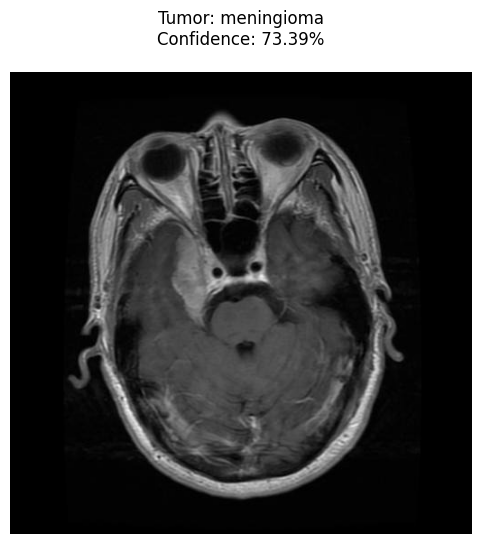


Detailed probabilities:
glioma              : 0.83%
meningioma          : 73.39%
notumor             : 1.16%
pituitary           : 24.62%


In [25]:
test_image = r"D:\Brain_Tumor\Training\meningioma\Tr-meTr_0003.jpg"
predict_tumor (test_image , model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


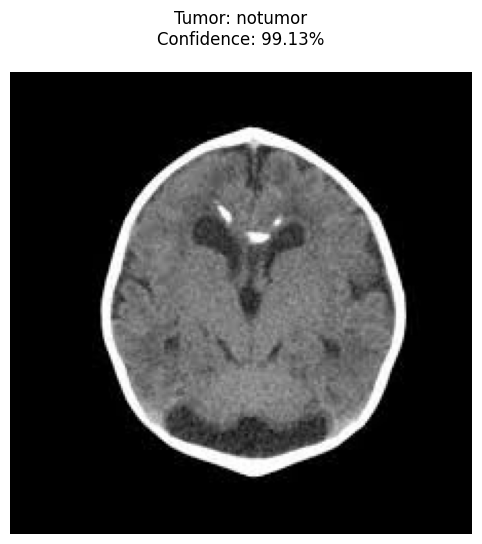


Detailed probabilities:
glioma              : 0.14%
meningioma          : 0.71%
notumor             : 99.13%
pituitary           : 0.02%


In [26]:
test_image = r"D:\Brain_Tumor\Training\notumor\Tr-no_0010.jpg"
predict_tumor(test_image,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


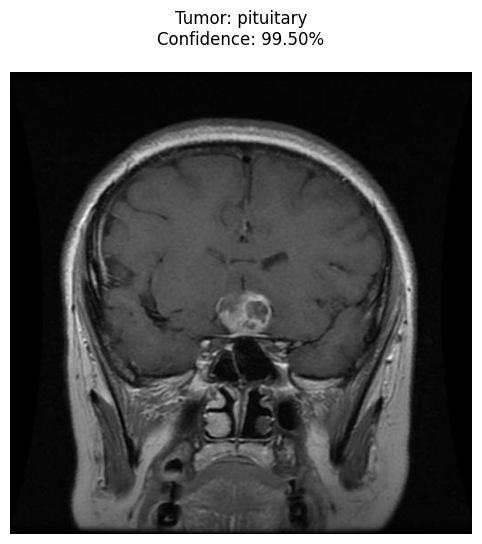


Detailed probabilities:
glioma              : 0.04%
meningioma          : 0.44%
notumor             : 0.02%
pituitary           : 99.50%


In [27]:
test_image = r"D:\Brain_Tumor\Training\pituitary\Tr-pi_0010.jpg"
predict_tumor(test_image, model)